# Setup

In [2]:
import cupy as cp
import numpy as np

if cp.cuda.is_available():
	print("GPU is available")
	print("GPU: ", cp.cuda.runtime.getDeviceProperties(0)['name'])
import os
import tempfile
from IPython.display import HTML, display
import h5py
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (5, 4)

import tdgl
from tdgl.geometry import box, circle
from tdgl.visualization.animate import create_animation

MAKE_ANIMATIONS = True


tempdir = tempfile.TemporaryDirectory()

def make_video_from_solution(
	solution,
	quantities=("order_parameter", "phase"),
	fps=30,
	figsize=(5, 4),
	cmap=None,
	vmin_a=None,
	vmax_a=None,
	cmap_b=None,
	):
	"""Generates an HTML5 video from a tdgl.Solution."""
	with tdgl.non_gui_backend():
		with h5py.File(solution.path, "r") as h5file:
			print(cmap_b)
			anim = create_animation(
				h5file,
				quantities=quantities,
				fps=fps,
				figure_kwargs=dict(figsize=figsize, dpi=100),
				vmin=vmin_a,
				vmax=vmax_a,
				cmap=cmap_b,
			)
			video = anim.to_html5_video()
		return HTML(video)
	

	

GPU is available
GPU:  b'NVIDIA GeForce RTX 4060 Laptop GPU'


c:\Program Files\Python310\lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


# Physical properties

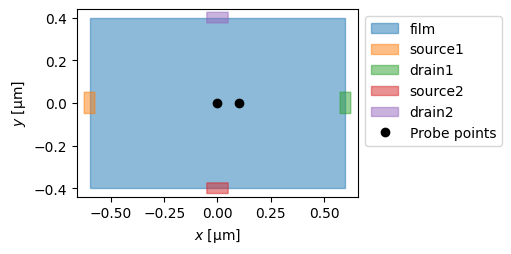

In [3]:
length_units = "um"
# Material parameters
xi = 0.1
london_lambda = 2
d = 0.1
layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=1)

width = 1.2
height = 0.8

film = tdgl.Polygon('film', points=box(width, height)).resample(401).buffer(0)


source1 = tdgl.Polygon('source1', points=box(0.05,0.1)).translate(-width/2, 0 ).buffer(0)
drain1 = tdgl.Polygon('drain1', points=box(0.05,0.1)).translate(width/2, 0 ).buffer(0)
source2 = tdgl.Polygon('source2', points=box(0.1,0.05)).translate(0,-height/2 ).buffer(0)
drain2 = tdgl.Polygon('drain2', points=box(0.1,0.05)).translate(0,height/2).buffer(0)


device=tdgl.Device("2currents",
				   layer=layer 
				   ,film=film
				   ,terminals= [source1,drain1,source2,drain2]
				   ,length_units=length_units
				   ,probe_points=[((0, 0),(0.1,0))]
				   )

fig,ax=device.draw()

Constructing Voronoi polygons: 100%|██████████| 5500/5500 [00:02<00:00, 2210.89it/s]


num_sites: 5500
num_elements: 10598
min_edge_length: 0.00607413918975885
max_edge_length: 0.024005788943875193
mean_edge_length: 0.014402366022712536
min_area: 2.148966835632236e-05
max_area: 0.0003763070462350327
mean_area: 0.00017454545454545457
coherence_length: 0.1
length_units: um


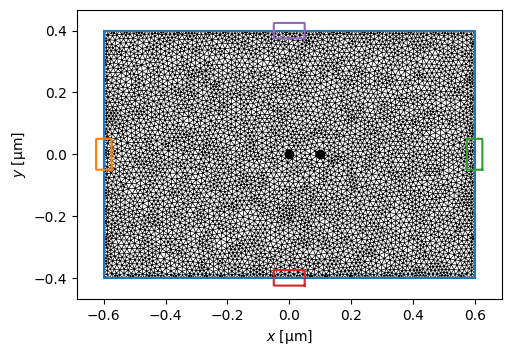

In [4]:
device.make_mesh(max_edge_length=xi / 4, smooth=100)
device.mesh_stats(print_b=True)
fig, ax = device.plot(mesh=True, legend=False)

Simulating: 100%|█████████▉| 300/300 [00:44<00:00,  6.75tau/s ]


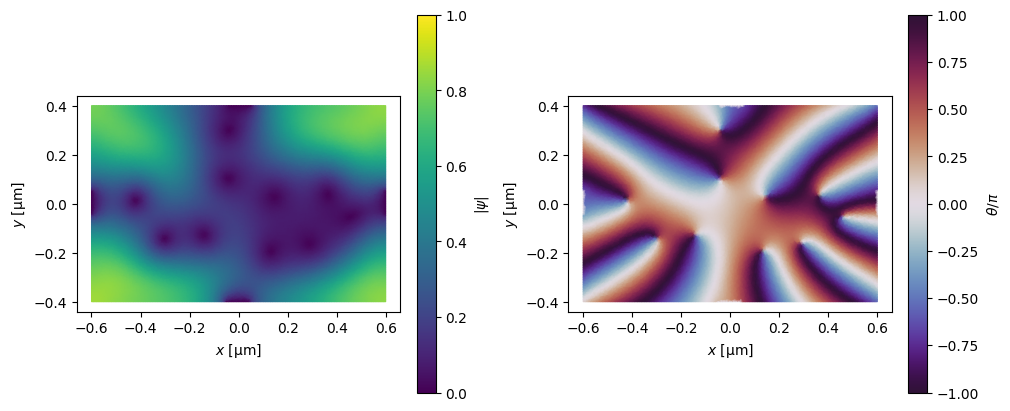

In [5]:


import tdgl.sources


options = tdgl.SolverOptions(
    solve_time=300,
    output_file=os.path.join(tempdir.name, "weak-link-zero-current.h5"),
    field_units = "mT",
    current_units="uA",

)
applied_vector_potential=tdgl.sources.constant.ConstantField(30,field_units=options.field_units,length_units=device.length_units)
zero_current_solution = tdgl.solve(
	device=device,
	options=options,
	applied_vector_potential=applied_vector_potential,
	terminal_currents=dict(source1=2, drain1=-2,source2=2,drain2=-2)
)
fig, axes = zero_current_solution.plot_order_parameter(figsize=(10, 4))

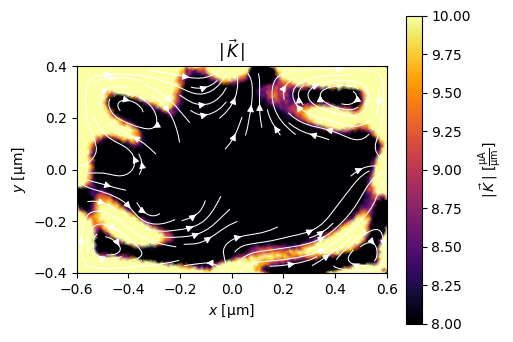

In [6]:
fig, ax = zero_current_solution.plot_currents(min_stream_amp=0.075, vmin=8, vmax=10)

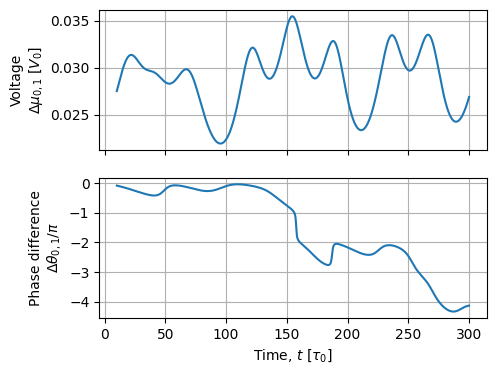

In [7]:
fig, axes = zero_current_solution.dynamics.plot(tmin=10, mean_voltage=False)

In [8]:
if MAKE_ANIMATIONS:
    field_current_video = make_video_from_solution(
        zero_current_solution,
        quantities=["order_parameter", "phase"],
        figsize=(8, 4),
        vmax_a=[1,1],
        vmin_a=[0,-1],
        cmap_b=["gist_rainbow", "hsv"],
    )
    display(field_current_video,)

['gist_rainbow', 'hsv']
